In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# mu = 3.986e14
mu = 1.0

# Analytical
def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec)))

def differential_equation(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(p_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    first_order_pder = np.zeros((n, n))
    p_vec = x_vec[:3]
    first_order_pder[:3, 3:] = np.eye(3)
    first_order_pder[3:, :3] = first_order_partial_derivatives(p_vec)
    return first_order_pder

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    second_order_pder = np.zeros((n * n, n))
    p_vec = x_vec[:3]
    aux = second_order_partial_derivatives(p_vec)
    for i in range(3):
        second_order_pder[n * i + 3:n * (i + 1), :3] = aux[3 * i:3 * (i + 1), :]
    return second_order_pder

def f(dt, x_old):
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)
    k4 = differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(np.eye(n), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1)) @ (dt / 2 * Hk1)
    Hk3 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(np.eye(n), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2)) @ (dt / 2 * Hk2)
    Hk4 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(np.eye(n), first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [18]:
def h(x_vec):
    return x_vec[:3]
    
def Dh(y, x_vec):
    o = len(y)
    n = len(x_vec)
    aux = np.zeros((o, n))
    aux[:, :3] = np.eye(o)  
    return aux

def HhT(y, x_vec):
    o = len(y)
    n = len(x_vec)
    return np.zeros((n * n, o))

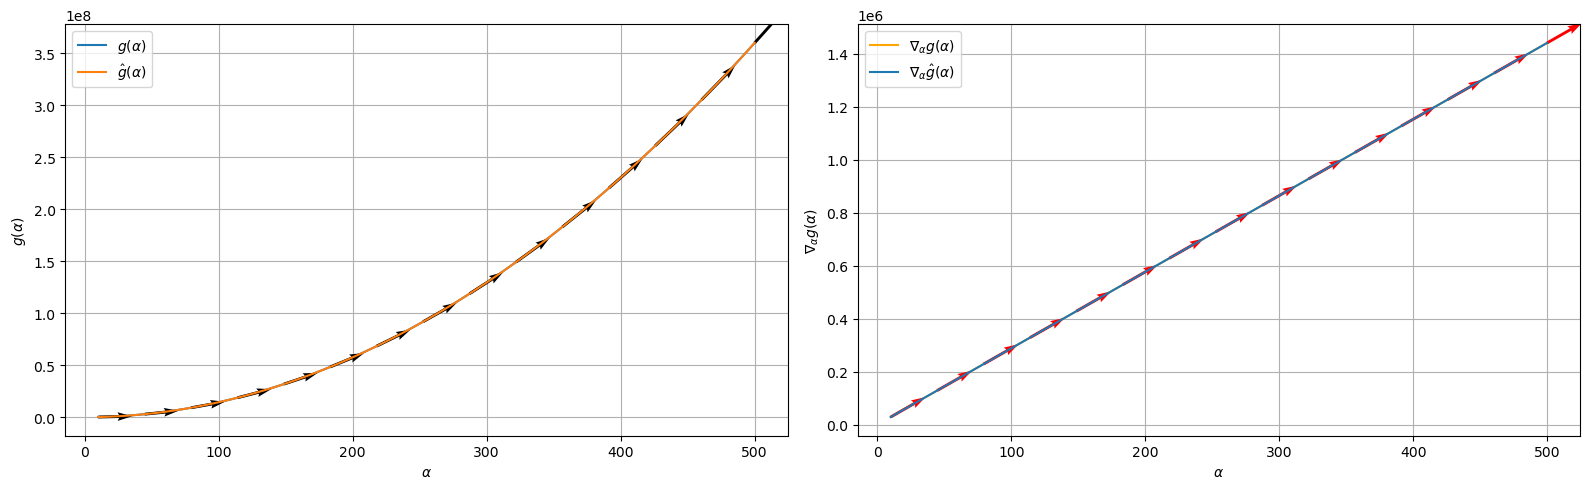

In [20]:
R = np.diag([1e0, 1e0, 1e0])

def cost_function(tau, dt, y, x_vec): # For the initial conditions, for now
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def cost_function_grad(tau, dt, y, x_vec):
    n = len(x_vec)
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(y, x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def cost_function_hessian(tau, dt, y, x_vec):
    n = len(x_vec)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = (np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM) 
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
        
    return -(DSTM @ Dh(y, sample_x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))).reshape((n, n)) + STM.T @ (Dh(y, x_vec).T @ np.linalg.inv(R) @ Dh(y, x_vec) - (HhT(y, x_vec) @ np.linalg.inv(R) @ (y - h(x_vec))).reshape((n, n))) @ STM

def test_function(tau, dt, y, alpha, x_vec):
    return cost_function(tau, dt, y, alpha * x_vec)

def test_function_grad(tau, dt, y, alpha, x_vec):
    return cost_function_grad(tau, dt, y, alpha * x_vec).T @ x_vec

def test_function_hessian(tau, dt, y, alpha, x_vec):
    return x_vec.T @ cost_function_hessian(tau, dt, y, alpha * x_vec) @ x_vec

def test_function_approx(tau, dt, y, alpha, x_vec, point=0):
    return test_function(tau, dt, y, point, x_vec) + (alpha - point) * test_function_grad(tau, dt, y, point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(tau, dt, y, point, x_vec)

def test_function_approx_grad(tau, dt, y, alpha, x_vec, point=0):
    return test_function_grad(tau, dt, y, point, x_vec) + (alpha - point) * test_function_hessian(tau, dt, y, point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

tau = 1
dt = 60.0
y = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

alpha_bounds = np.linspace(1e1, 5e2, 100)
cost_values = np.array([test_function(tau, dt, y, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(tau, dt, y, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(tau, dt, y, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(tau, dt, y, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(tau, dt, y, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 15
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)

axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$', color='orange')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)

axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()